In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm, chi2


# Step 1: Download HDFC Bank data
ticker = "HDFCBANK.NS"
end_date = datetime.today()
start_date = end_date - timedelta(days=2*365)
df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))

# Use Adjusted Close if available, else fallback
if "Adj Close" in df.columns:
    prices = df["Adj Close"].dropna()
else:
    prices = df["Close"].dropna()

S0 = float(prices.iloc[-1])  # last observed price

C:\Users\aniru\AppData\Local\Temp\ipykernel_14628\3975433345.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed
C:\Users\aniru\AppData\Local\Temp\ipykernel_14628\3975433345.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.iloc[-1])  # last observed price


In [3]:
# Step 2: Estimate drift (mu) and volatility (sigma) with confidence intervals
def estimate_params(prices, trading_days=252):
    logp = np.log(prices)
    r = logp.diff().dropna()
    N = len(r)
    dt = 1.0 / trading_days

    r_mean = r.mean()
    s2 = r.var(ddof=1)
    sigma_hat = np.sqrt(s2 / dt)
    mu_hat = (r_mean / dt) + 0.5 * sigma_hat ** 2

    # Confidence intervals
    se_mu = sigma_hat / np.sqrt(N * dt)
    z = norm.ppf(0.975)
    mu_ci = (mu_hat - z * se_mu, mu_hat + z * se_mu)

    chi_low = chi2.ppf(0.025, df=N - 1)
    chi_high = chi2.ppf(0.975, df=N - 1)
    sigma_ci = (
        np.sqrt((N - 1) * s2 / chi_high / dt),
        np.sqrt((N - 1) * s2 / chi_low / dt)
    )

    return float(mu_hat), float(sigma_hat), mu_ci, sigma_ci

mu, sigma, mu_ci, sigma_ci = estimate_params(prices)

C:\Users\aniru\AppData\Local\Temp\ipykernel_14628\1065049344.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(mu_hat), float(sigma_hat), mu_ci, sigma_ci


In [4]:
# Step 3: Monte Carlo Simulation (GBM)
def simulate_gbm(S0, mu, sigma, T=1.0, trading_days=252, n_sims=1000, seed=42):
    np.random.seed(seed)
    dt = T / trading_days
    Z = np.random.normal(size=(n_sims, trading_days))
    increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.hstack([np.zeros((n_sims, 1)), log_paths])
    return S0 * np.exp(log_paths)

paths = simulate_gbm(S0, mu, sigma, n_sims=1000)
ending_prices = paths[:, -1]

In [5]:
# Step 4: Summary Stats
print("=== Parameter Estimates (Annualized) ===")
print(f"Drift (mu): {mu:.4f}")
print(f"95% CI for mu: ({float(mu_ci[0]):.4f}, {float(mu_ci[1]):.4f})")
print(f"Volatility (sigma): {sigma:.4f}")
print(f"95% CI for sigma: ({float(sigma_ci[0]):.4f}, {float(sigma_ci[1]):.4f})\n")

print("=== Simulation Results (1 Year Ahead) ===")
print(f"Initial Price S0: {S0:.2f}")
print(f"Expected Price (mean): {ending_prices.mean():.2f}")
print(f"Median Price: {np.median(ending_prices):.2f}")
p2_5, p97_5 = np.percentile(ending_prices, [2.5, 97.5])
print(f"95% Simulation Interval: [{p2_5:.2f}, {p97_5:.2f}]")
print(f"Probability S_T > S0: {np.mean(ending_prices > S0):.2%}")

=== Parameter Estimates (Annualized) ===
Drift (mu): 0.1244
95% CI for mu: (-0.1560, 0.4049)
Volatility (sigma): 0.1999
95% CI for sigma: (0.1882, 0.2133)

=== Simulation Results (1 Year Ahead) ===
Initial Price S0: 965.90
Expected Price (mean): 1093.45
Median Price: 1080.85
95% Simulation Interval: [721.39, 1557.14]
Probability S_T > S0: 70.30%


C:\Users\aniru\AppData\Local\Temp\ipykernel_14628\169790042.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"95% CI for mu: ({float(mu_ci[0]):.4f}, {float(mu_ci[1]):.4f})")
C:\Users\aniru\AppData\Local\Temp\ipykernel_14628\169790042.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"95% CI for sigma: ({float(sigma_ci[0]):.4f}, {float(sigma_ci[1]):.4f})\n")


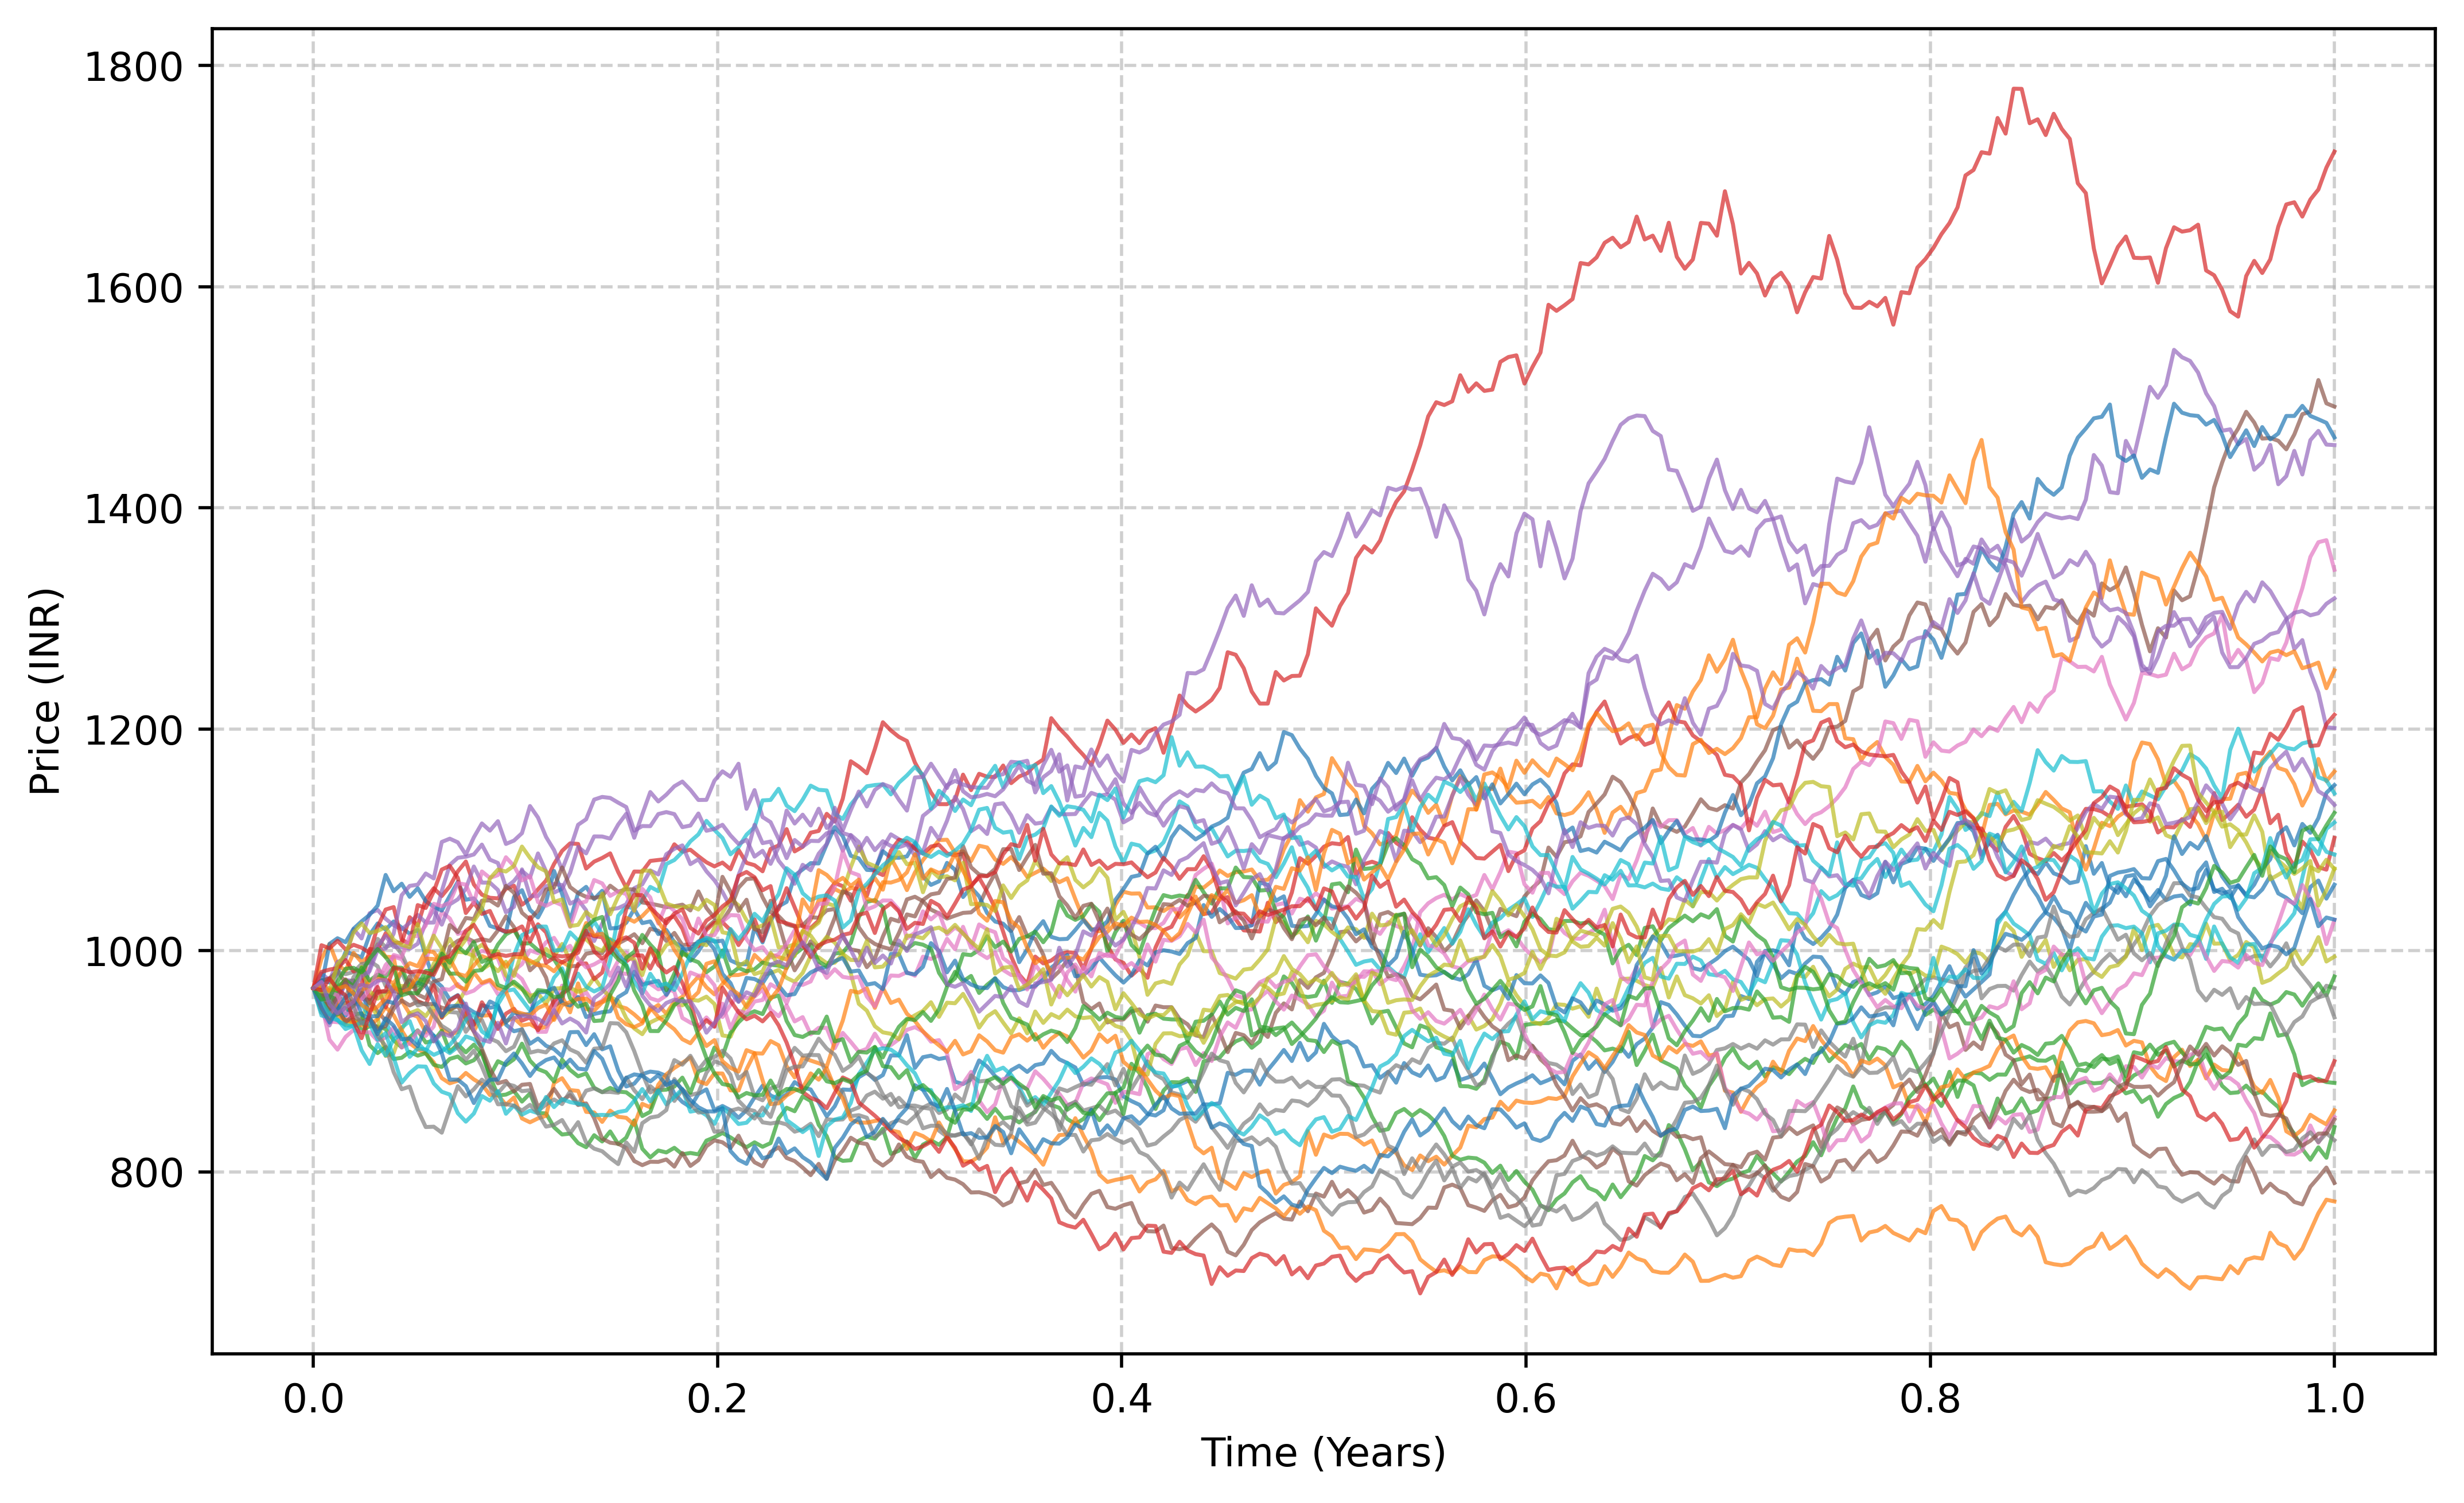

In [11]:
# Step 5a: Visualization of simulated paths
plt.figure(figsize=(10,6), dpi =500)
plt.figure
trading_days = 252
T = 1.0
time_grid = np.linspace(0, T, trading_days + 1)  # from 0 to 1 year

# Plot only a subset of paths for readability
n_plot = 35
for i in range(n_plot):
    plt.plot(time_grid, paths[i], lw=1, alpha=0.7)

#plt.title("Monte Carlo Simulation of HDFC Bank Stock Price (GBM)")
plt.xlabel("Time (Years)")
plt.ylabel("Price (INR)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

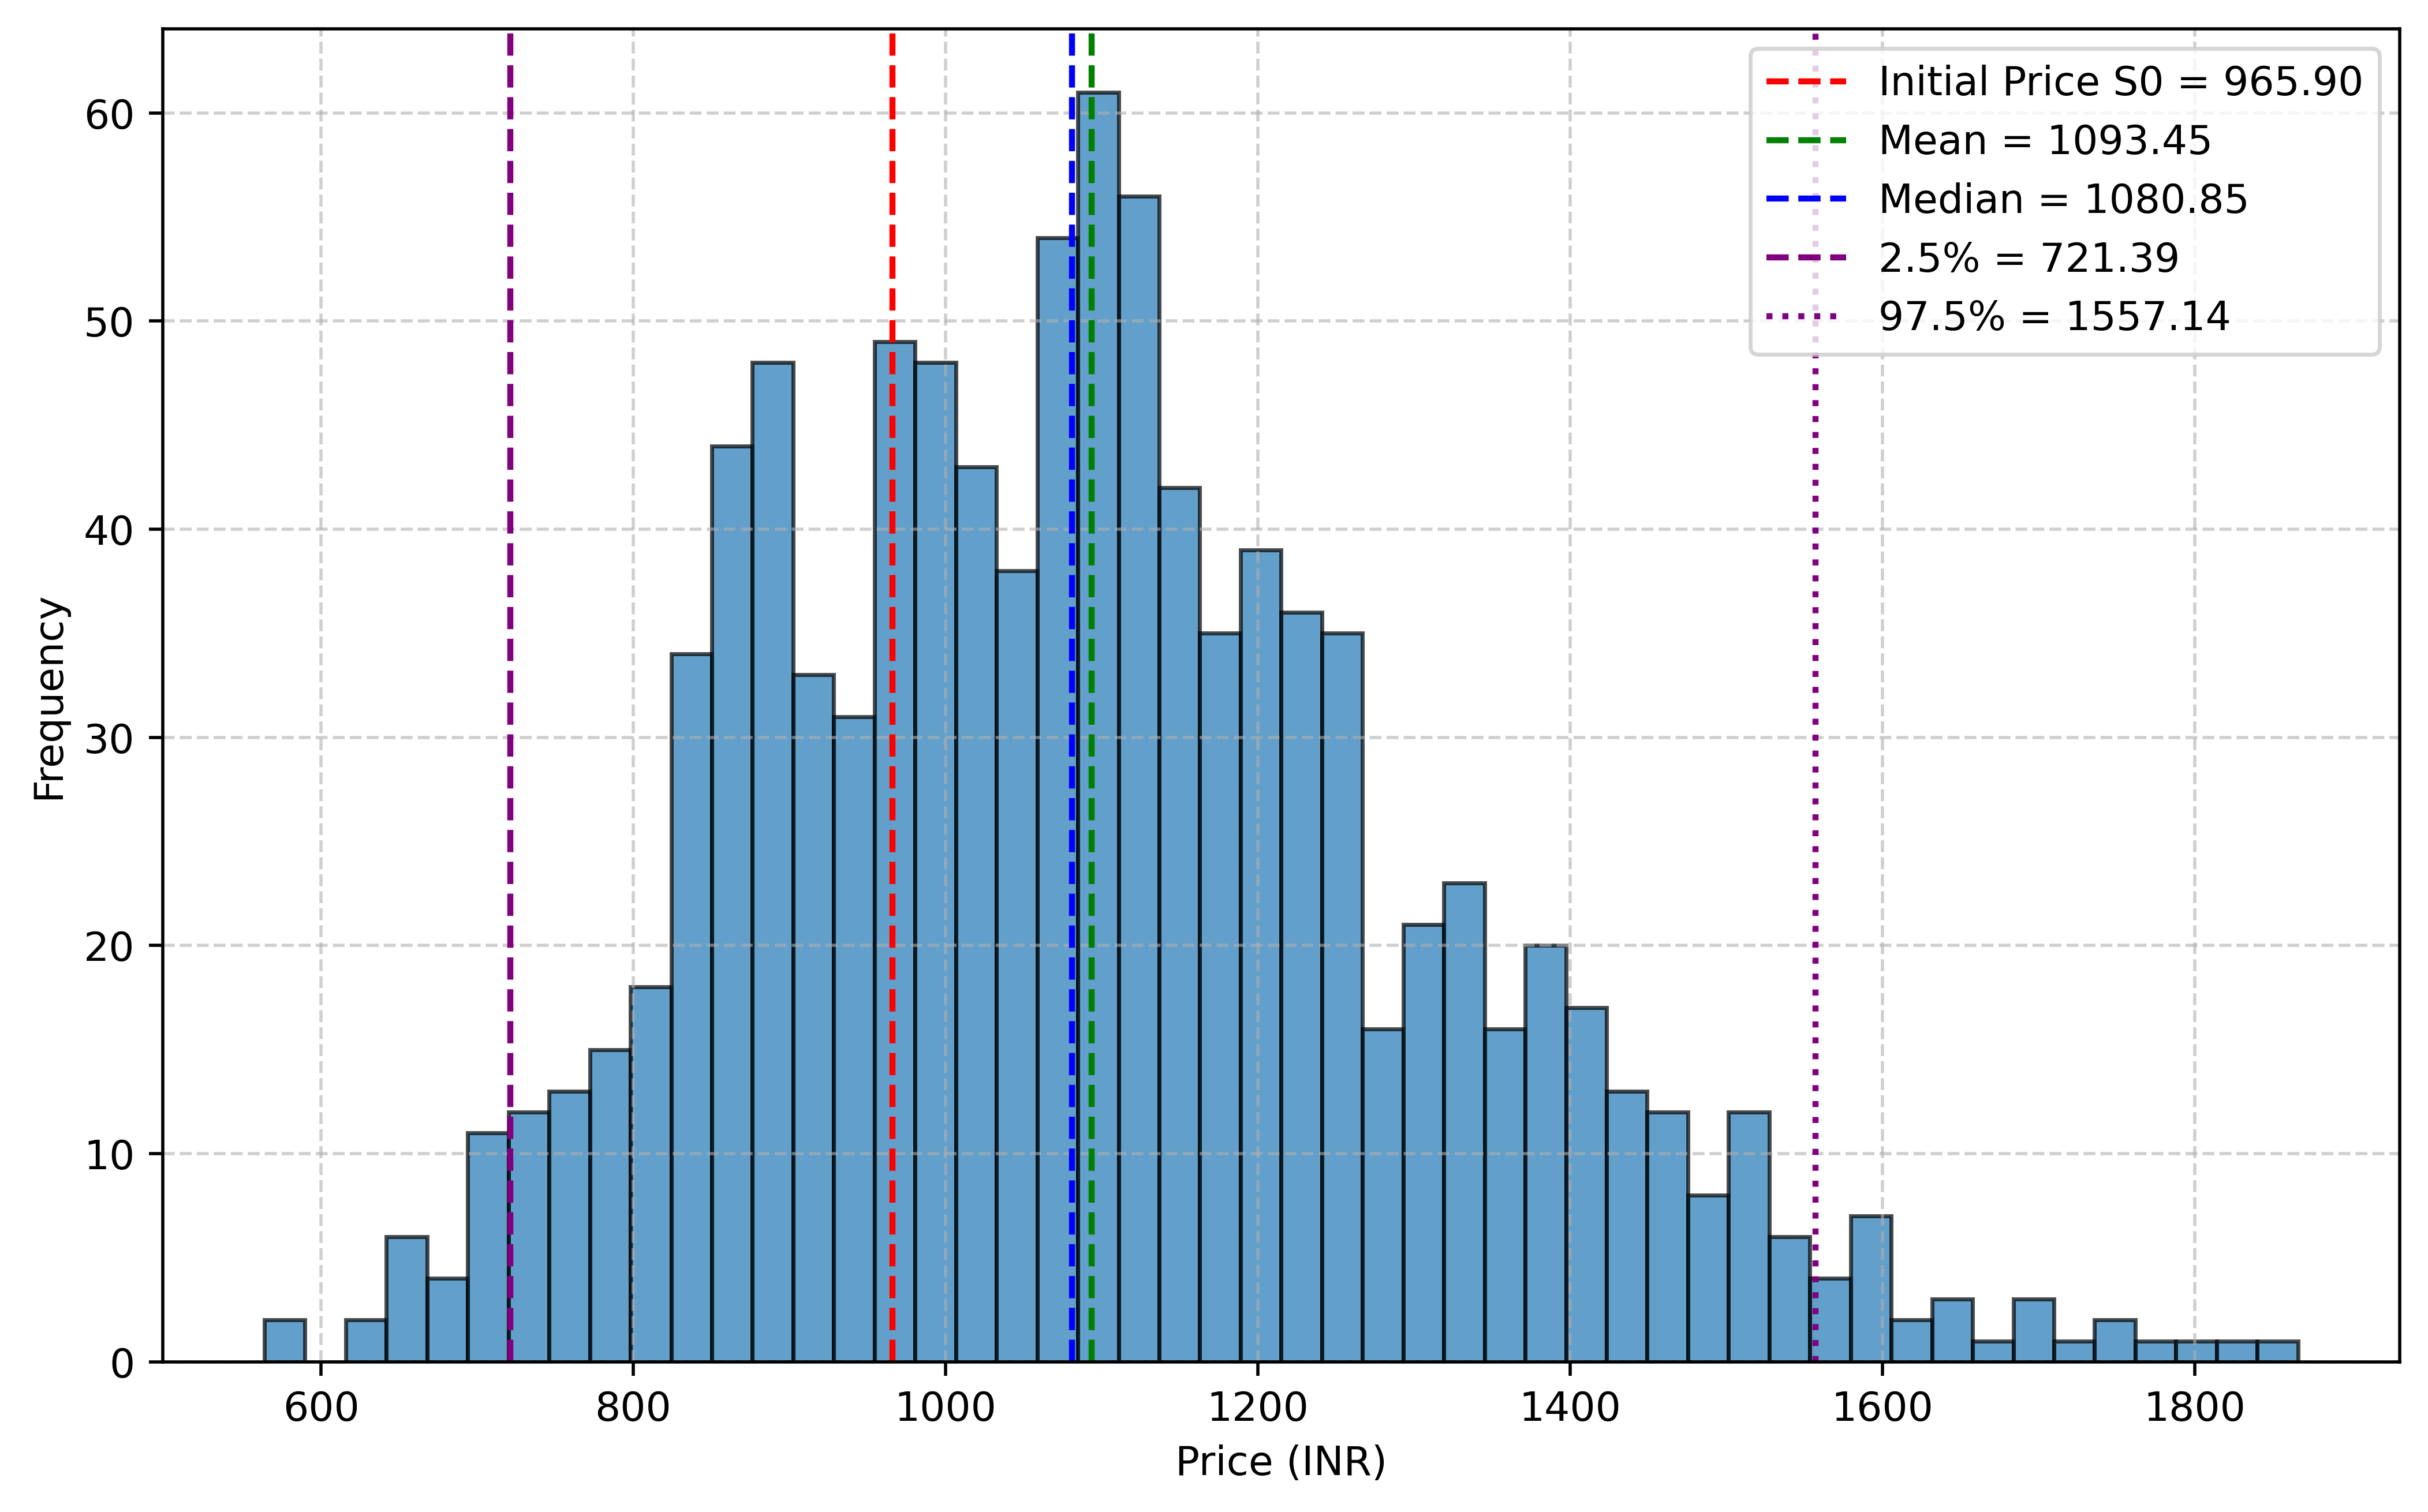

In [12]:
plt.figure(figsize=(10,6), dpi=500)
plt.hist(ending_prices, bins=50, alpha=0.7, edgecolor="black")

# Reference lines
plt.axvline(S0, color="red", linestyle="--", label=f"Initial Price S0 = {S0:.2f}")
plt.axvline(ending_prices.mean(), color="green", linestyle="--", label=f"Mean = {ending_prices.mean():.2f}")
plt.axvline(np.median(ending_prices), color="blue", linestyle="--", label=f"Median = {np.median(ending_prices):.2f}")

# 95% simulation interval
p2_5, p97_5 = np.percentile(ending_prices, [2.5, 97.5])
plt.axvline(p2_5, color="purple", linestyle="--", label=f"2.5% = {p2_5:.2f}")
plt.axvline(p97_5, color="purple", linestyle=":", label=f"97.5% = {p97_5:.2f}")

#plt.title("Distribution of Simulated Ending Prices (1 Year)")
plt.xlabel("Price (INR)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()